<a href="https://colab.research.google.com/github/pranshudatascience/Bio-Medical-Image-segmentation-of-Covid-19-lesion-ct-scan/blob/main/resUnet_Segmentation_Model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"datasciencepranshu","key":"f206fef76574e388b3dba86a1861be62"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d maedemaftouni/covid19-ct-scan-lesion-segmentation-dataset

 99% 681M/688M [00:16<00:00, 41.3MB/s]
100% 688M/688M [00:16<00:00, 43.0MB/s]


# **Extracting Data by Unzipping the File**

In [ ]:
from zipfile import ZipFile
file_name = "covid19-ct-scan-lesion-segmentation-dataset.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model



# **Developing the U-NET Architecture for mage segmentation**

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, Input
from tensorflow.keras.models import Model

def batchnorm_relu(inputs):
    """ Batch Normalization & ReLU """
    x = BatchNormalization()(inputs)
    x = Activation("relu")(x)
    return x

def residual_block(inputs, num_filters, strides=1):
    """ Convolutional Layers """
    x = batchnorm_relu(inputs)
    x = Conv2D(num_filters, 3, padding="same", strides=strides)(x)
    x = batchnorm_relu(x)
    x = Conv2D(num_filters, 3, padding="same", strides=1)(x)

    """ Shortcut Connection (Identity Mapping) """
    s = Conv2D(num_filters, 1, padding="same", strides=strides)(inputs)

    """ Addition """
    x = x + s
    return x

def decoder_block(inputs, skip_features, num_filters):
    """ Decoder Block """

    x = UpSampling2D((2, 2))(inputs)
    x = Concatenate()([x, skip_features])
    x = residual_block(x, num_filters, strides=1)
    return x

def build_resunet(input_shape):
    """ RESUNET Architecture """

    inputs = Input(input_shape)

    """ Endoder 1 """
    x = Conv2D(64, 3, padding="same", strides=1)(inputs)
    x = batchnorm_relu(x)
    x = Conv2D(64, 3, padding="same", strides=1)(x)
    s = Conv2D(64, 1, padding="same")(inputs)
    s1 = x + s

    """ Encoder 2, 3 """
    s2 = residual_block(s1, 128, strides=2)
    s3 = residual_block(s2, 256, strides=2)

    """ Bridge """
    b = residual_block(s3, 512, strides=2)

    """ Decoder 1, 2, 3 """
    x = decoder_block(b, s3, 256)
    x = decoder_block(x, s2, 128)
    x = decoder_block(x, s1, 64)

    """ Classifier """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(x)

    """ Model """
    model = Model(inputs, outputs, name="RESUNET")

    return model

if __name__ == "__main__":
    shape = (224, 224, 3)
    model = build_resunet(shape)
    model.summary()

Model: "RESUNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                           

In [ ]:
from keras.utils.vis_utils import plot_model

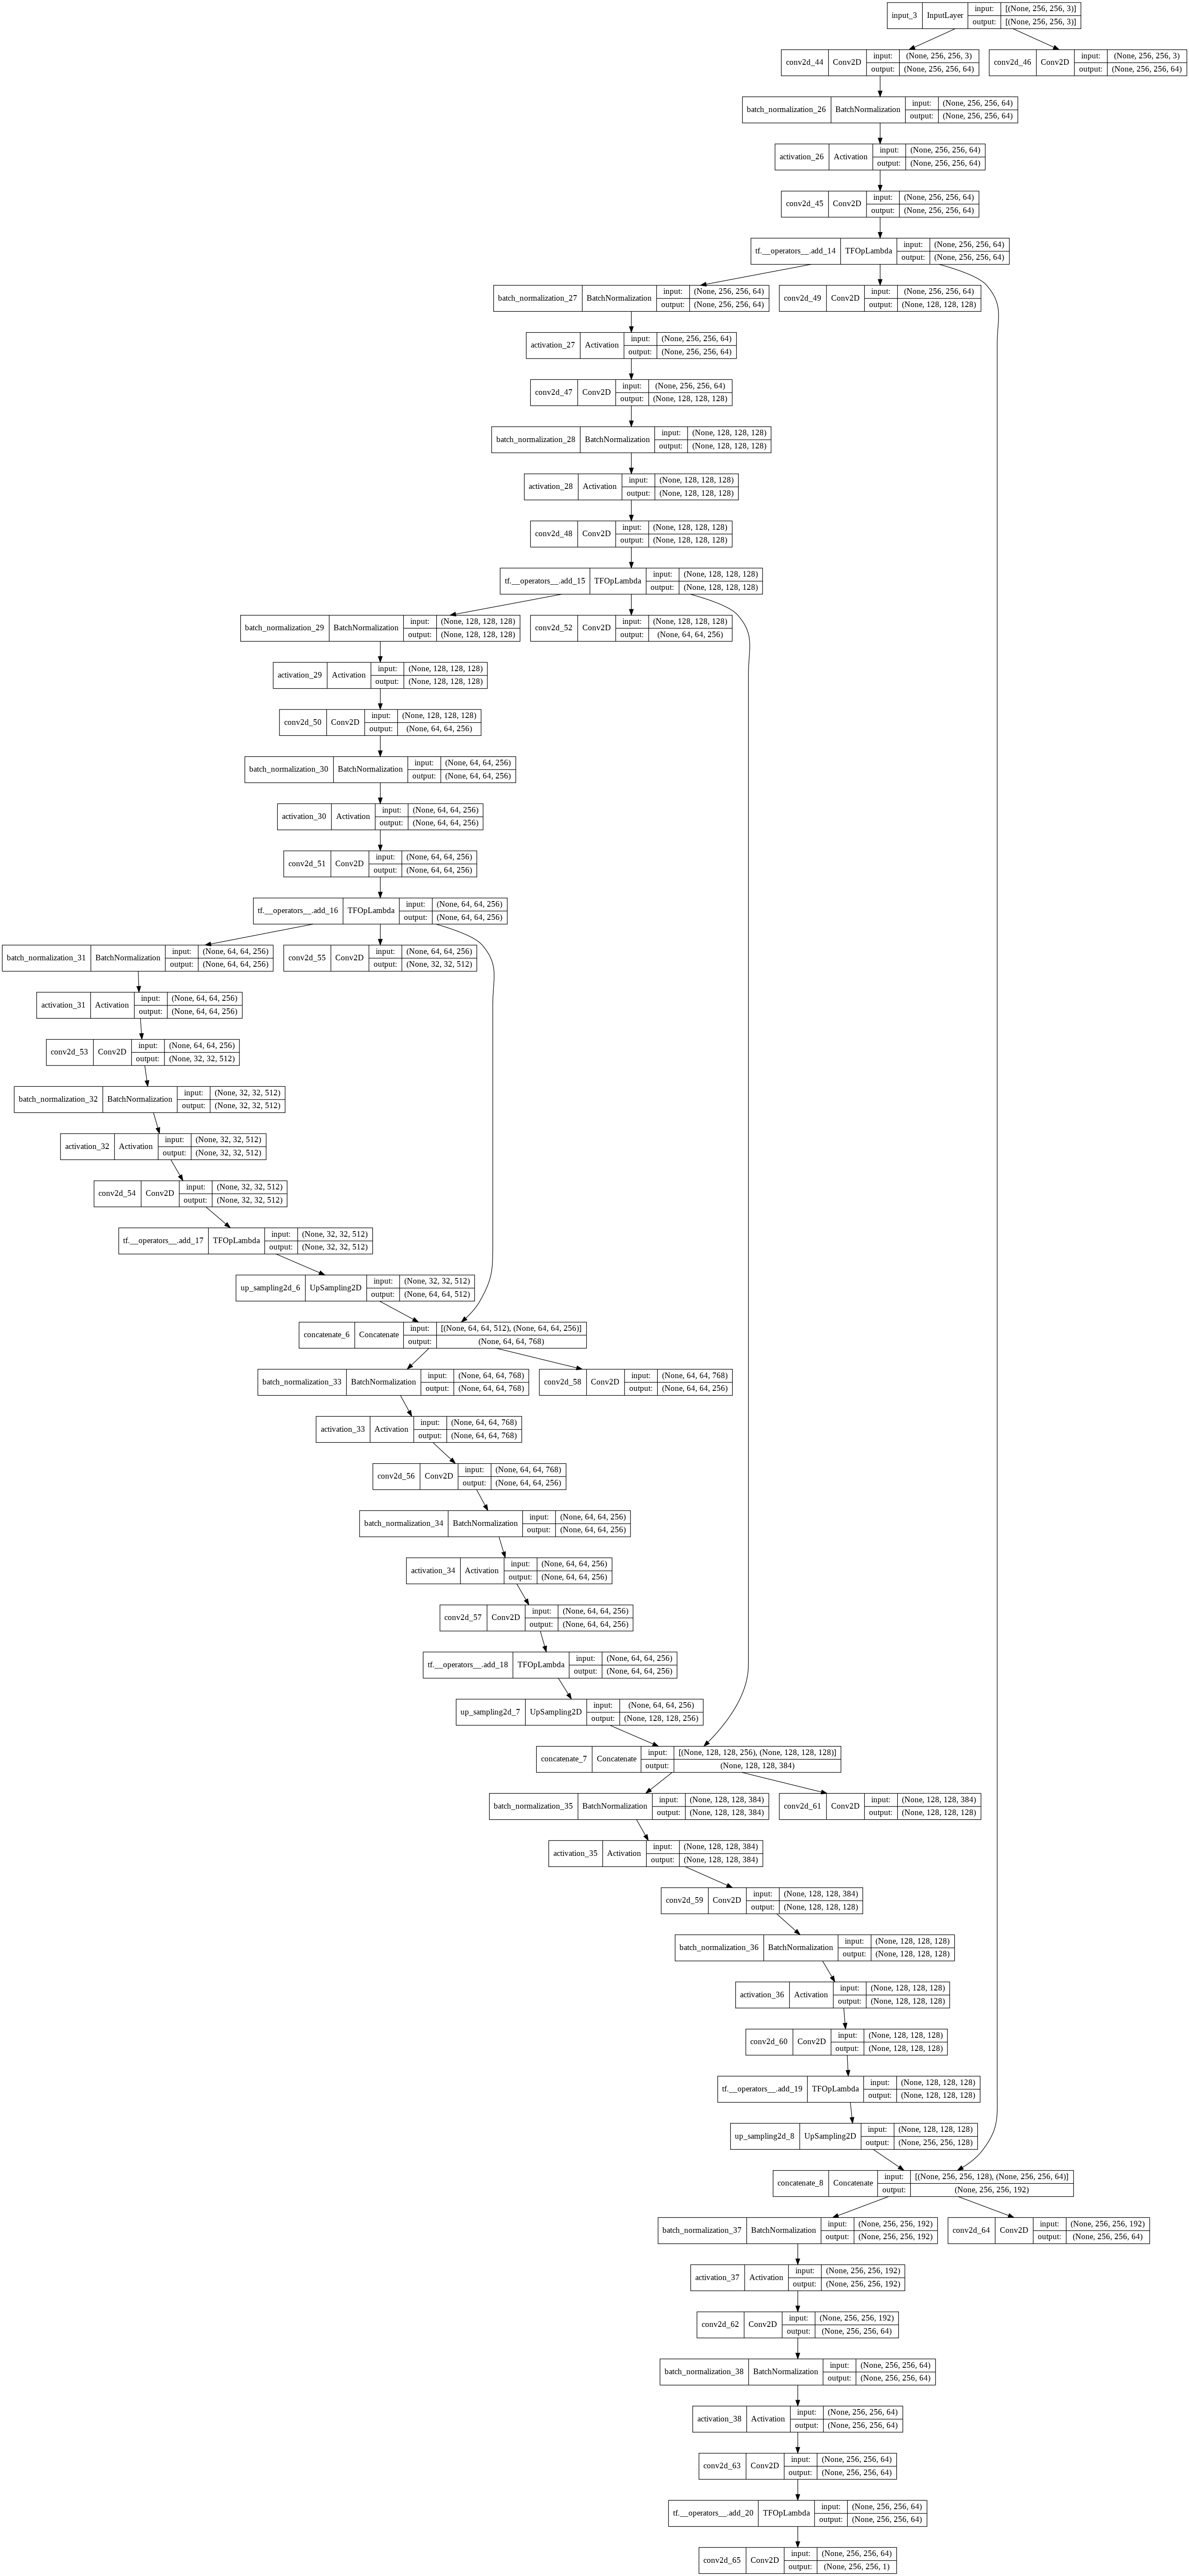

In [ ]:
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K



def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
#from model import build_unet
#from metrics import dice_coef, iou

H = 256
W = 256

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

def load_data(dataset_path, split=0.2):
    images = sorted(glob(os.path.join(dataset_path, "frames", "*.png")))
    masks = sorted(glob(os.path.join(dataset_path, "masks", "*.png")))

    test_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=test_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=test_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)  ## (H, W, 3)
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    return x                                ## (256, 256, 3)

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (H, W)
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)                    ## (256, 256)
    x = np.expand_dims(x, axis=-1)              ## (256, 256, 1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Folder for saving data """
    create_dir("files")

    """ Hyperparameters """
    batch_size = 4
    lr = 1e-4 ## (0.0001)
    num_epoch = 15
    model_path = "files/model.h5"
    csv_path = "files/data.csv"

    """ Dataset : 60/20/20 """
    dataset_path = "/content/data"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(dataset_path)

    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Valid: {len(valid_x)} - {len(valid_y)}")
    print(f"Test: {len(test_x)} - {len(test_y)}")

    train_dataset = tf_dataset(train_x, train_y, batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y, batch_size)

    train_steps = len(train_x)//batch_size
    valid_steps = len(valid_x)//batch_size

    if len(train_x) % batch_size != 0:
        train_steps += 1

    if len(valid_x) % batch_size != 0:
        valid_steps += 1

    """ Model """
    model = build_resunet((H, W, 3))
    metrics = [dice_coef, iou, Recall(), Precision()]
    model.compile(loss="binary_crossentropy", optimizer=Adam(lr), metrics=metrics)
    model.summary()

    callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        TensorBoard(),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)
    ]

    model.fit(
        train_dataset,
        epochs=num_epoch,
        validation_data=valid_dataset,
        steps_per_epoch=train_steps,
        validation_steps=valid_steps,
        callbacks=callbacks
    )

Train: 1639 - 1639
Valid: 545 - 545
Test: 545 - 545
Model: "RESUNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_44 (Conv2D)             (None, 256, 256, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_26 (BatchN  (None, 256, 256, 64  256        ['conv2d_44[0][0]']              
 ormalization)                  )       

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
import pandas as pd
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
#from sklearn.metrics import dice_loss, dice_coef, iou
#from train import load_data, create_dir



In [ ]:
H = 256
W = 256

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=0)   ## (1, 256, 256, 3)
    return ori_x, x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x > 0.5
    x = x.astype(np.int32)
    return ori_x, x

def save_result(ori_x, ori_y, y_pred, save_path):
    line = np.ones((H, 10, 3)) * 255

    ori_y = np.expand_dims(ori_y, axis=-1) ## (256, 256, 1)
    ori_y = np.concatenate([ori_y, ori_y, ori_y], axis=-1) ## (256, 256, 3)

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1) * 255.0

    cat_images = np.concatenate([ori_x, line, ori_y, line, y_pred], axis=1)
    cv2.imwrite(save_path, cat_images)

if __name__ == "__main__":
    create_dir("results")

    """ Load Model """
    with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef}):
        model = tf.keras.models.load_model("files/model.h5")

    """ Dataset """
    dataset_path = "/content/data"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(dataset_path)

     
    SCORE = []

    for i in range(len(test_x)):
        x= test_x[i]
        y= test_y[i]
        name = x.split("/")[-1]
    #for x, y in tqdm((test_x, test_y), total=len(test_x)):
       # name = x.split("/")[-1]

        """ Reading the image and mask """
        ori_x, x = read_image(x)
        ori_y, y = read_mask(y)

        """ Prediction """
        y_pred = model.predict(x)[0] > 0.5
        y_pred = np.squeeze(y_pred, axis=-1)
        y_pred = y_pred.astype(np.int32)

        save_path = f"results/{name}"
        save_result(ori_x, ori_y, y_pred, save_path)

        """ Flattening the numpy arrays. """
        y = y.flatten()
        y_pred = y_pred.flatten()

        """ Calculating metrics values """
        acc_value = accuracy_score(y, y_pred)
        f1_value = f1_score(y, y_pred, labels=[0, 1], average="binary")
        jac_value = jaccard_score(y, y_pred, labels=[0, 1], average="binary")
        recall_value = recall_score(y, y_pred, labels=[0, 1], average="binary")
        precision_value = precision_score(y, y_pred, labels=[0, 1], average="binary")
        SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value])

    """ Metrics values """
    score = [s[1:]for s in SCORE]
    score = np.mean(score, axis=0)
    print(f"Accuracy: {score[0]:0.5f}")
    print(f"F1: {score[1]:0.5f}")
    print(f"Jaccard: {score[2]:0.5f}")
    print(f"Recall: {score[3]:0.5f}")
    print(f"Precision: {score[4]:0.5f}")

    """ Saving all the results """
    df = pd.DataFrame(SCORE, columns=["Image", "Accuracy", "F1", "Jaccard", "Recall", "Precision"])
    df.to_csv("files/score.csv")

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined a

Accuracy: 0.99365
F1: 0.66031
Jaccard: 0.54648
Recall: 0.59945
Precision: 0.81303


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
    """ Metrics values """
    score = [s[1:]for s in SCORE]
    score = np.mean(score, axis=0)
    print(f"Accuracy: {score[0]:0.5f}")
    print(f"F1: {score[1]:0.5f}")
    print(f"Jaccard: {score[2]:0.5f}")
    print(f"Recall: {score[3]:0.5f}")
    print(f"Precision: {score[4]:0.5f}")

Accuracy: 0.99365
F1: 0.66031
Jaccard: 0.54648
Recall: 0.59945
Precision: 0.81303


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
